# Exploratory analysis of my personal health data

## Setup

In [5]:
import os
import datetime
import json
# from sqlalchemy import create_engine

import altair as alt
# import panel as pn
# pn.extension('vega')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

# from scipy.interpolate import interp1d

pd.set_option('display.max_rows', 500)

In [6]:
data_dir = os.path.join('/','Users','jamieinfinity','Dropbox','Projects','WeightForecaster','_data_dump')
filename_weight = os.path.join(data_dir, 'weight', 'weight_full.csv')
filename_activities = os.path.join(data_dir, 'fitbit', 'activities', 'activities.csv')
filename_food = os.path.join(data_dir, 'food', 'food_tot.csv')
steps_detail_dir = os.path.join(data_dir, 'fitbit', 'detailed_steps')
hr_detail_dir = os.path.join(data_dir, 'fitbit', 'detailed_heart_rate')

**NOTES**

```
○ Weight Forecaster:
	○ data analysis
		○ steps:
			○ investigate Fitbit metrics assigned to a given day:
				○ plot bar chart of steps
				○ highlight periods tagged as run, walk, sport
				○ how do active minutes relate to this?
			○ investigate possible error registering steps while driving
				○ focus on road trip to Eyeo (doesn't require Automatic data)
				○ how bad is it for commuting? For this you need to align Automatic data with steps
			○ additional EDA: ???
		○ calories:
			○ investigate how reliable / complete the carb/fat/protein breakdown is
			○ investigate cleaning up treatment of alcoholic beverages: proper breakdown would be carbs / alcohol
			○ do a little EDA
				○ rank foods by frequency or calories etc
                
```

## Load data

In [7]:
wgt_raw = pd.read_csv(filename_weight)
wgt_raw.tail()

,date,weight,wgt_ame,wgt_logger,wgt_withings,timestamp,Fat mass (lb),Bone mass (lb),Muscle mass (lb),Hydration (lb)
2859,2020-10-30,155.3,NaN,NaN,155.3,2020-10-30 06:33:53,24.9,6.5,123.9,88.9
2860,2020-10-31,154.9,NaN,NaN,154.9,2020-10-31 06:39:30,25.0,6.5,123.5,88.5
2861,2020-11-01,154.8,NaN,NaN,154.8,2020-11-01 05:46:34,23.7,6.5,124.4,89.8
2862,2020-11-02,153.7,NaN,NaN,153.7,2020-11-02 06:30:55,24.1,6.5,123.1,88.3
2863,2020-11-03,154.3,NaN,NaN,154.3,2020-11-03 05:33:18,24.1,6.5,123.7,88.9


In [8]:
act_raw = pd.read_csv(filename_activities)
act_raw.tail()

,date,timestamp,duration_mins,activity_type,calories,steps
3106,2020-11-01,2020-11-01 07:18,69.98,Walk,466.0,7148.0
3107,2020-11-01,2020-11-01 14:52,39.25,Walk,274.0,3996.0
3108,2020-11-02,2020-11-02 14:12,48.63,Walk,352.0,5050.0
3109,2020-11-03,2020-11-03 06:48,56.33,Walk,398.0,5821.0
3110,2020-11-03,2020-11-03 15:32,31.58,Walk,217.0,3178.0


In [9]:
food_raw = pd.read_csv(filename_food)
food_raw.tail()

,date,calories,carbohydrates,fat,protein,sodium,sugar
1871,2020-10-30,2195.0,231.0,106.0,114.0,2858.0,56.0
1872,2020-10-31,2245.0,238.0,116.0,93.0,3018.0,72.0
1873,2020-11-01,1974.0,205.0,98.0,104.0,2750.0,31.0
1874,2020-11-02,1926.0,157.0,115.0,96.0,2081.0,23.0
1875,2020-11-03,2200.0,223.0,104.0,123.0,3531.0,38.0


## Explore weight fluctuations

### Impact of jogging before weighing

**NOTES**

Based on the findings below, it's clear that there is strong evidence that jogging before weighing myself impacts the measurement:
   * If I jogged today, but not yesterday, the mean shift is -1.73.
   * If I didn't jog today, but did yesterday, the mean shift is 1.69.    
   * If I did the same today as yesterday, there is negligible shift: -0.03.

 

In [123]:
wgt_df = wgt_raw[wgt_raw.date >= act_raw.date.min()][['date', 'weight', 'timestamp']].copy().reset_index(drop=True)

temp_df = act_raw[act_raw.activity_type=='Run'][['date','timestamp']].copy().reset_index(drop=True).rename({'timestamp':'run_time'},axis=1)

wgt_df = pd.merge(wgt_df, temp_df, how='left', on='date')
wgt_df['run_before'] = [int(x) for x in wgt_df.run_time < wgt_df.timestamp]
wgt_df.drop(['timestamp', 'run_time'], axis=1, inplace=True)
wgt_df['wgt_diff'] = wgt_df.weight.diff()
wgt_df['rb_diff'] = wgt_df.run_before.diff()

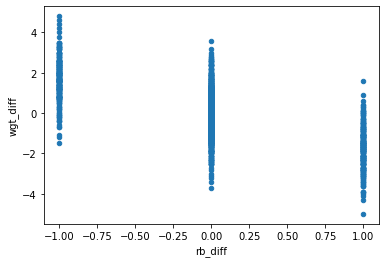

In [124]:
wgt_df.plot.scatter(x='rb_diff', y='wgt_diff')

plt.show()

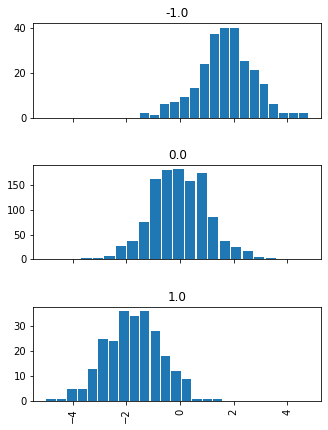

In [125]:
wgt_df[['wgt_diff', 'rb_diff']].hist(column='wgt_diff', by='rb_diff', 
                                     bins=17, grid=False, figsize=(5,7), layout=(3,1), sharex=True, rwidth=0.9)

plt.show()

In [126]:
wgt_df.groupby('rb_diff').mean()

,weight,run_before,wgt_diff
rb_diff,,,
-1.0,168.736905,0.000000,1.691270
0.0,171.986081,0.085385,-0.029128
1.0,167.030040,1.000000,-1.729200


In [128]:
wgt_df.groupby('rb_diff').std()

,weight,run_before,wgt_diff
rb_diff,,,
-1.0,7.777782,0.000000,1.041377
0.0,6.509100,0.279561,1.038479
1.0,7.886731,0.000000,1.038142


In [129]:
wgt_df.wgt_diff.std()

1.3967635856901692

### Impact of amount of food eaten day before

**NOTES**

Based on the findings below, there is slight evidence showing that if I ate a lot more/less yesterday than the previous day, my weight will shift up/down compared to what I weighed yesterday.

However, I hesitate to use this to adjust for weight fluctuations. 

I could look at this from slightly different angles:

   * I could pull in just the dinner calories and repeat the calculation, since that might have a bigger impact on my weight since it is closer in time
   * instead of comparing to measurements shifted back a day, I could calculate a 7 day rolling avg and take the difference to that. But this seems too contrived / complex of an effect (and too similar to the eventual linear regression model)
   
What I'm trying to capture by looking at the calories is actually the mass of food consumed, which calories is a poor proxy for. The effect I'm really trying to capture is one I have no data on, which is whether I defecate in the morning before weighing. If I had a label for this, I'm guessing it would have as strong of correlation as the above jogging effect.

The only hope I might have of detecting if I do defecate in the morning is by looking for an indirect signal in my granular steps and heart rate data. In the morning, while walking around, my heart rate is elevated (~80 or so). When I sit down, it adjusts and decreases. It might be worthwhile to try to detect this in the data.

In [130]:
wgt_df = wgt_raw[wgt_raw.date >= food_raw.date.min()][['date', 'timestamp', 'weight']].copy().reset_index(drop=True)
wgt_df['wgt_diff'] = wgt_df.weight.diff()

wgt_df = pd.merge(wgt_df, food_raw[['date', 'calories']], how='left', on='date')
wgt_df['cal_m1'] = wgt_df.calories.shift(1)
wgt_df['cal_m2'] = wgt_df.calories.shift(2)
wgt_df['cal_diff'] = wgt_df.cal_m1 - wgt_df.cal_m2
# wgt_df.drop(['calories'], axis=1, inplace=True)

wgt_df = wgt_df[wgt_df.date >= act_raw.date.min()].copy().reset_index(drop=True)
temp_df = act_raw[act_raw.activity_type=='Run'][['date','timestamp']].copy().reset_index(drop=True).rename({'timestamp':'run_time'},axis=1)
wgt_df = pd.merge(wgt_df, temp_df, how='left', on='date')

wgt_df['run_before'] = [int(x) for x in wgt_df.run_time < wgt_df.timestamp]
wgt_df.drop(['timestamp', 'run_time'], axis=1, inplace=True)
wgt_df['rb_diff'] = wgt_df.run_before.diff()

wgt_df.tail(25)

,date,weight,wgt_diff,calories,cal_m1,cal_m2,cal_diff,run_before,rb_diff
1782,2020-10-10,152.8,-2.7,2186.0,2309.0,2177.0,132.0,1,1.0
1783,2020-10-11,154.0,1.2,2101.0,2186.0,2309.0,-123.0,0,-1.0
1784,2020-10-12,152.8,-1.2,2394.0,2101.0,2186.0,-85.0,1,1.0
1785,2020-10-13,155.6,2.8,2319.0,2394.0,2101.0,293.0,0,-1.0
1786,2020-10-14,153.9,-1.7,2129.0,2319.0,2394.0,-75.0,1,1.0
1787,2020-10-15,155.1,1.2,1992.0,2129.0,2319.0,-190.0,0,-1.0
1788,2020-10-16,154.2,-0.9,3436.0,1992.0,2129.0,-137.0,0,0.0
1789,2020-10-17,154.3,0.1,3082.0,3436.0,1992.0,1444.0,1,1.0
1790,2020-10-18,156.9,2.6,2438.0,3082.0,3436.0,-354.0,0,-1.0
1791,2020-10-19,156.5,-0.4,1895.0,2438.0,3082.0,-644.0,0,0.0


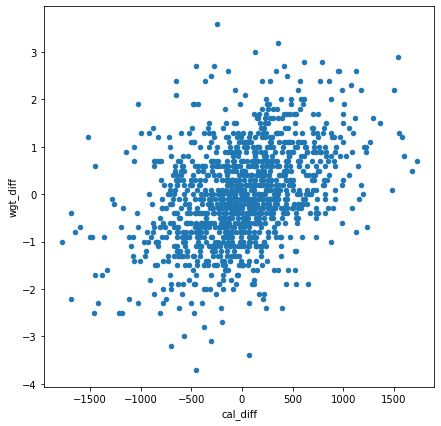

In [132]:
# temp_df = wgt_df.copy()
temp_df = wgt_df[wgt_df.rb_diff==0.0].copy()

temp_df.plot.scatter(x='cal_diff', y='wgt_diff', figsize=(7,7))

plt.show()

### Impact of defecating before weighing

**NOTES**

Below, I attempt to visually detect a signal in the steps and heart rate that might correlate to defecating, but the heart rate signal is very noisy. It might be possible if I had labeled data and could run a supervised learning model. I was hoping there might be an obvious signature, i.e. steps drops to zero, heart rate drops as I sit down, but the heart rate data seems way too noisy to try and pick something like that out. Even while I'm sleeping, the signal is all over the place.



In [133]:
wgt_df = wgt_raw[wgt_raw.date >= act_raw.date.min()][['date', 'weight', 'timestamp']].copy().reset_index(drop=True)

temp_df = act_raw[act_raw.activity_type=='Run'][['date','timestamp']].copy().reset_index(drop=True).rename({'timestamp':'run_time'},axis=1)

wgt_df = pd.merge(wgt_df, temp_df, how='left', on='date')
wgt_df['run_before'] = [int(x) for x in wgt_df.run_time < wgt_df.timestamp]
wgt_df.drop(['timestamp', 'run_time'], axis=1, inplace=True)
wgt_df['wgt_diff'] = wgt_df.weight.diff()
wgt_df['rb_diff'] = wgt_df.run_before.diff()

In [137]:
foo = wgt_df[(wgt_df.date>='2017-05-01') & (wgt_df.date<'2017-07-01')]
foo.head(10)

,date,weight,run_before,wgt_diff,rb_diff
524,2017-05-01,167.9,0,0.1,0.0
525,2017-05-02,168.1,0,0.2,0.0
526,2017-05-03,169.7,0,1.6,0.0
527,2017-05-04,168.3,0,-1.4,0.0
528,2017-05-05,167.8,0,-0.5,0.0
529,2017-05-06,166.3,1,-1.5,1.0
530,2017-05-07,166.3,1,0.0,0.0
531,2017-05-08,167.9,0,1.6,-1.0
532,2017-05-09,169.0,0,1.1,0.0
533,2017-05-10,168.7,0,-0.3,0.0


In [191]:
hr_detail_file = os.path.join(hr_detail_dir, 'heart_detail_2016-12-26_to_2017-07-13.json')
steps_detail_file = os.path.join(steps_detail_dir, 'steps_detail_2016-12-26_to_2017-07-13.json')

with open(hr_detail_file) as data_file:
    hr_detail = json.load(data_file)

with open(steps_detail_file) as data_file:
    steps_detail = json.load(data_file)

In [192]:
def get_detail(chunk, date, datatype):
    res = [x for x in chunk if x[datatype][0]['dateTime']==date][0]
    res = pd.DataFrame(res[datatype + '-intraday']['dataset'])
    res['timestamp'] = pd.to_datetime([date + ' ' + x for x in res.time])
    return res[['timestamp', 'value']]

In [225]:
d = '2017-05-02'
hr_df = get_detail(hr_detail, d, 'activities-heart')
steps_df = get_detail(steps_detail, d, 'activities-steps')

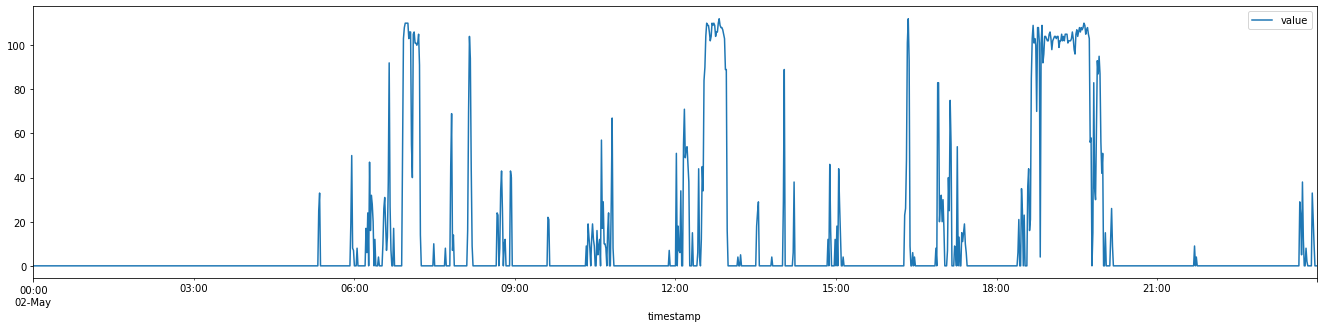

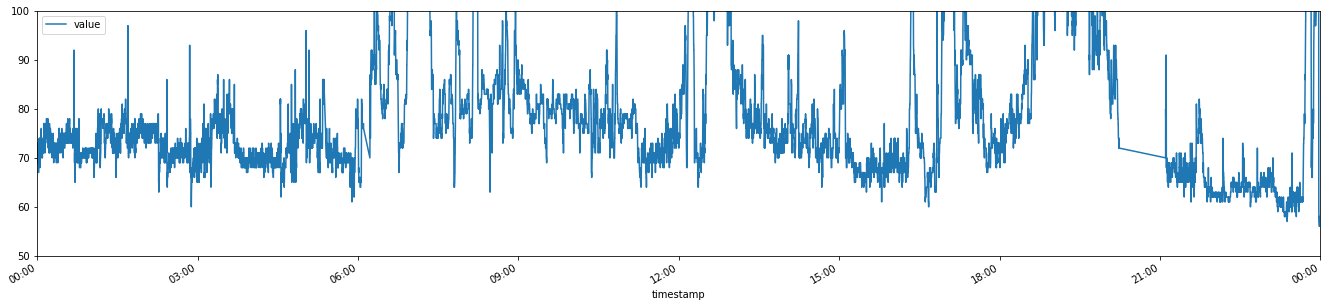

In [226]:
steps_df.plot(x='timestamp', y='value', figsize=(23, 5))

hr_df.plot(x='timestamp', y='value', figsize=(23, 5))

ax=plt.gca()
ax.set_xlim(['2017-05-02', '2017-05-03'])
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax.set_ylim([50, 100])

plt.show()

## Adjust for effect of jogging/sweating weight decrease

TODO:
* tag days if you jogged before weighing
* for days that you did jog, add 1.7 to the measured weight
* compare the adjusted and unadjusted weights:
   * visually on timeline (with rolling 7day avg)
   * look at distribution of prev. day diff and diff from 7 day roll avg


In [320]:
wgt_df = wgt_raw[wgt_raw.date >= act_raw.date.min()][['date', 'weight', 'timestamp']].copy().reset_index(drop=True)

temp_df = act_raw[act_raw.activity_type=='Run'][['date','timestamp']].copy().reset_index(drop=True).rename({'timestamp':'run_time'},axis=1)

wgt_df = pd.merge(wgt_df, temp_df, how='left', on='date')
wgt_df['run_before'] = [int(x) for x in wgt_df.run_time < wgt_df.timestamp]
wgt_df.drop(['timestamp', 'run_time'], axis=1, inplace=True)
wgt_df['wgt_diff'] = wgt_df.weight.diff()
wgt_df['rb_diff'] = wgt_df.run_before.diff()

wgt_df['wgt_no_rb'] = wgt_df.apply(lambda x: np.nan if x['run_before']==1 else x['weight'], axis=1)

wgt_df.date = pd.to_datetime(wgt_df.date)
wgt_df.set_index('date', inplace=True)

wgt_df['wgt_no_rb_int'] = wgt_df.wgt_no_rb.values
wgt_df.wgt_no_rb_int.interpolate(limit=7,  method='spline', order=2, inplace=True)

period = '7D'
min_periods = 1
wgt_df['wgt_no_rb_int_roll7d'] = wgt_df.wgt_no_rb_int.rolling(period, min_periods=min_periods).mean()

wgt_df['wgt_offset'] = wgt_df.weight - wgt_df.wgt_no_rb_int_roll7d

jog_offset = 1.73
wgt_df['weight_adj'] = wgt_df.apply(lambda x: (x['weight'] + jog_offset) if x['run_before']==1 else x['weight'], axis=1)
wgt_df['weight_adj_roll7d'] = wgt_df.weight_adj.rolling(period, min_periods=min_periods).mean()
wgt_df['wgt_adj_diff'] = wgt_df.weight_adj - wgt_df.weight_adj_roll7d

In [321]:
wgt_df.head(10)

,weight,run_before,wgt_diff,rb_diff,wgt_no_rb,wgt_no_rb_int,wgt_no_rb_int_roll7d,wgt_offset,weight_adj,weight_adj_roll7d,wgt_adj_diff
date,,,,,,,,,,,
2015-11-24,175.0,0,NaN,NaN,175.0,175.000000,175.000000,0.000000,175.00,175.000000,0.000000
2015-11-25,175.3,0,0.3,0.0,175.3,175.300000,175.150000,0.150000,175.30,175.150000,0.150000
2015-11-26,173.9,1,-1.4,1.0,NaN,175.241674,175.180558,-1.280558,175.63,175.310000,0.320000
2015-11-27,175.1,0,1.2,-1.0,175.1,175.100000,175.160419,-0.060419,175.10,175.257500,-0.157500
2015-11-28,174.1,1,-1.0,1.0,NaN,175.169331,175.162201,-1.062201,175.83,175.372000,0.458000
2015-11-29,173.8,1,-0.3,0.0,NaN,175.129881,175.156814,-1.356814,175.53,175.398333,0.131667
2015-11-30,176.0,0,2.2,-1.0,176.0,176.000000,175.277269,0.722731,176.00,175.484286,0.515714
2015-12-01,173.3,1,-2.7,1.0,NaN,175.044429,175.283616,-1.983616,175.03,175.488571,-0.458571
2015-12-02,174.1,0,0.8,-1.0,174.1,174.100000,175.112188,-1.012188,174.10,175.317143,-1.217143


In [322]:
dr = wgt_df.copy()
dr['date'] = dr.index
# xs = ('2015-9-01', '2021-1-31')
xs = ('2019-12-1', '2021-1-1')
ys = (153, 183)
width = 900
height = 450

w=alt.Chart(dr).mark_circle(size=60, opacity=0.3, color='black').encode(
    x=alt.X('date',
        scale=alt.Scale(domain=xs)
    ),  
    y=alt.Y('weight_adj',
        scale=alt.Scale(domain=ys)
    ),      
    tooltip=['date', 'run_before', 'weight', 'weight_adj', 'weight_adj_roll7d']
).properties(
    width=width,
    height=height
).interactive()

w_7d_avg=alt.Chart(dr).mark_line(opacity=0.7, color='black').encode(
    x='date',   
    y=alt.Y('weight_adj_roll7d',
        scale=alt.Scale(domain=ys)
    ),      
    tooltip=['date', 'run_before', 'weight', 'weight_adj', 'weight_adj_roll7d']
).properties(
    width=width,
    height=height
).interactive()

w + w_7d_avg

alt.LayerChart(...)

(-1.7310159033060946, 1.0365144054329103)


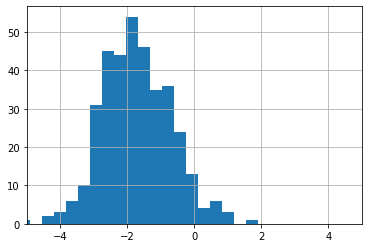

In [311]:
wgt_df[wgt_df.run_before==1].wgt_offset.hist(bins=20)

plt.xlim([-5, 5])

m = wgt_df[wgt_df.run_before==1].wgt_offset.mean()
s = wgt_df[wgt_df.run_before==1].wgt_offset.std()

print((m, s))

plt.show()

(-0.03159456264684935, 0.8793327254175177)


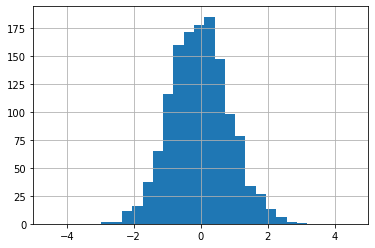

In [312]:
wgt_df[wgt_df.run_before==0].wgt_offset.hist(bins=20)

plt.xlim([-5, 5])

m = wgt_df[wgt_df.run_before==0].wgt_offset.mean()
s = wgt_df[wgt_df.run_before==0].wgt_offset.std()

print((m, s))

plt.show()

(-0.39270919662231163, 1.1489950025969504)


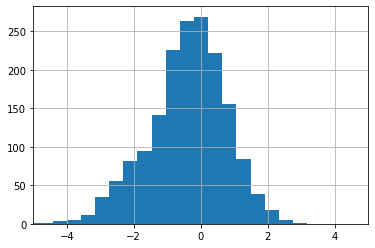

In [313]:
wgt_df.wgt_offset.hist(bins=20)

plt.xlim([-5, 5])

m = wgt_df.wgt_offset.mean()
s = wgt_df.wgt_offset.std()

print((m, s))

plt.show()

(-0.03106253270579129, 0.8891763747156637)


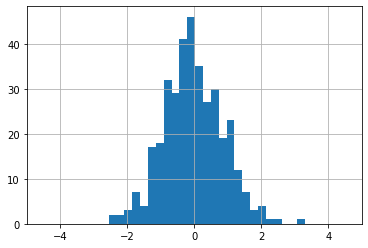

In [323]:
wgt_df[wgt_df.run_before==1].wgt_adj_diff.hist(bins=25)

plt.xlim([-5, 5])

m = wgt_df[wgt_df.run_before==1].wgt_adj_diff.mean()
s = wgt_df[wgt_df.run_before==1].wgt_adj_diff.std()

print((m, s))

plt.show()

(-0.05291506936395657, 0.8837413303894798)


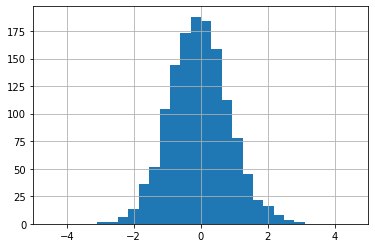

In [324]:
wgt_df[wgt_df.run_before==0].wgt_adj_diff.hist(bins=20)

plt.xlim([-5, 5])

m = wgt_df[wgt_df.run_before==0].wgt_adj_diff.mean()
s = wgt_df[wgt_df.run_before==0].wgt_adj_diff.std()

print((m, s))

plt.show()

(-0.04827156478510534, 0.8846839142728927)


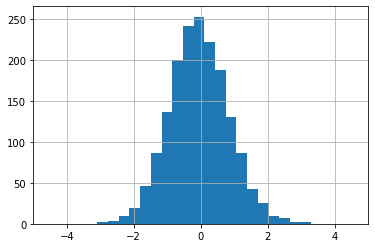

In [325]:
wgt_df.wgt_adj_diff.hist(bins=20)

plt.xlim([-5, 5])

m = wgt_df.wgt_adj_diff.mean()
s = wgt_df.wgt_adj_diff.std()

print((m, s))

plt.show()